## Import Dependencies and Dataframe

In [1]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from dfa import dfa
import scipy.signal as sig
import statistics as st
import scipy
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import interp1d
from scipy.integrate import romb
plt.rcParams.update({'font.size': 22})

In [2]:
df = p.load(open('df.p','rb'))

all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

## Book-Keeping Functions with Examples

In [3]:
# Book-keeping Functions
n_splits = 1

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return np.ravel(df.loc[measure, epoch][num_to_subject(subjno)])
    elif isinstance(epoch, int):
        return np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)])

def get_split_signal(measure, epoch, subjno, splitno):
    if isinstance(epoch,str):
        return np.array_split(np.ravel(df.loc[measure, epoch][num_to_subject(subjno)]), n_splits)[splitno]
    elif isinstance(epoch, int):
        return np.array_split(np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)]),n_splits)[splitno]
    
def full_signal(measure, subjno):
    return np.concatenate((
        np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)]),
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)])
    s2 = np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)])
    s3 = np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)])
    s4 = np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)])
    s5 = np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)])
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

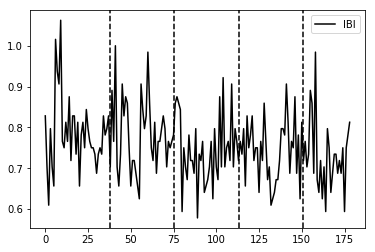

In [4]:
plot_full_experiment('IBI',26)

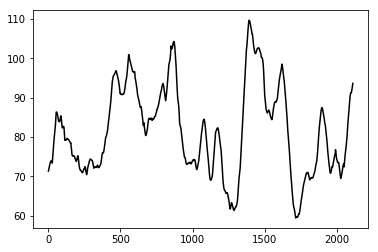

In [5]:
plt.plot(get_signal('HR',2,41), 'k') ## Gets the signal for any epoch, with epochs numbered 0-4

## Feature Sandbox

### Duplicate the following entire section for each function you want to write:

#### Feature 1: HR Frequency Mode

In [10]:
# Get sample signal 

signal = get_signal('HR', 3, 12)

# Define analysis function

def mode_frequency(signal):
    fs,pxx = sig.welch(signal, nfft = 1000, scaling = 'spectrum', detrend = 'constant')
    return fs[np.argmax(pxx)]

# Test function

mode_frequency(signal)

0.004

In [11]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];
n_splits = 100
for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('HR',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = mode_frequency(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:07<00:00,  4.37it/s]


ANOVA P-value = 0.535


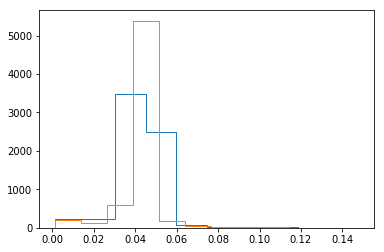

In [12]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

#### Feature 2: [Your Feature]

In [13]:
# IBI_mode with 1 split
# P val .280 for 2 splits 
# P val .221 for 3 splits

signal = get_signal('BVP', 3, 12)

# Define analysis function

def IBI_mode(signal):
    fs,pxx = sig.welch(signal, nfft = 1000, scaling = 'spectrum', detrend = 'constant')
    return fs[np.argmax(pxx)]

# Test function
IBI_mode(signal)

0.013000000000000001

In [14]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];
n_splits = 3
for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('IBI',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature =  IBI_mode(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

  0%|          | 0/33 [00:00<?, ?it/s]/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 77, using nperseg = 77
  .format(nperseg, input_length))
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 76, using nperseg = 76
  .format(nperseg, input_length))
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 154, using nperseg = 154
  .format(nperseg, input_length))
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 153, using nperseg = 153
  .format(nperseg, input_length))
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than i

 52%|█████▏    | 17/33 [00:00<00:00, 164.34it/s]/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 16, using nperseg = 16
  .format(nperseg, input_length))
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 31, using nperseg = 31
  .format(nperseg, input_length))
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 39, using nperseg = 39
  .format(nperseg, input_length))
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 54, using nperseg = 54
  .format(nperseg, input_length))
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 256 is greater 

ANOVA P-value = 0.221


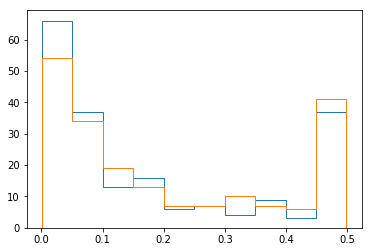

In [15]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

## test 2

In [16]:
# STD with 1 split
signal = get_signal('IBI', 3, 12)

# Define analysis function

def IBI_std(signal):
    return scipy.std(signal)

# Test function
IBI_std(signal)

0.07756473119917326

In [17]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('IBI',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature =  IBI_std(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 292.10it/s]


ANOVA P-value = 0.002


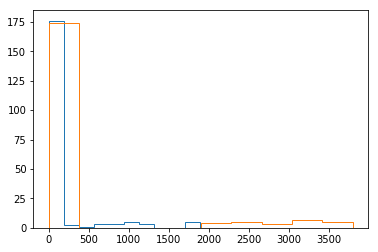

In [18]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

test 3

In [19]:
# Avg difference between highest and lowest
# 1 split pval = .837
# 3 split pval = .764
# 6 split pval = .690


signal = get_signal('IBI', 3, 12)
list = []
# Define analysis function

def maxmin_test(signal):
    #for splitno in range(n_splits):
    max_value = max(signal)
    min_value = min(signal)
        #list.append(max_value - min_value)
    return max_value - min_value#st.mean(list)

# Test function
maxmin_test(signal)

0.25001000000000007

In [20]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('IBI',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature =  maxmin_test(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 337.25it/s]


ANOVA P-value = 0.003


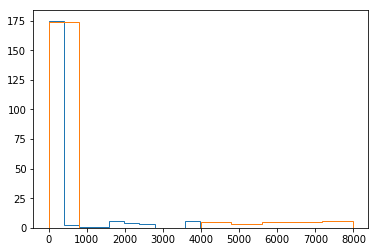

In [21]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

std of the mean with multiple splits 

In [22]:
# std of the mean with multiple splits
# 1 split pval = .645
# 3 split pval = .144
# 6 split pval = .733


signal = get_signal('IBI', 3, 12)
list = []
# Define analysis function

def stdMean_test(signal):
   # for splitno in range(n_splits):
  #list.append(st.mean(signal))
    return scipy.std(signal)

# Test function
stdMean_test(signal)

0.07756473119917326

In [23]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('IBI',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature =  stdMean_test(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 302.68it/s]


ANOVA P-value = 0.002


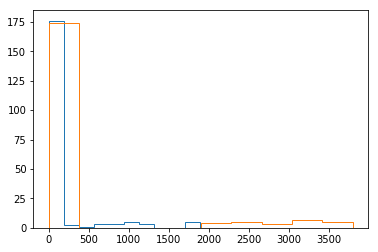

In [24]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

mean of std 

In [25]:
# test for mean of STD w multiple splits 

In [26]:
# mean of std with multiple splits
# 1 split pval = .832
# 3 split pval = .765
# 6 split pval = 0.950


signal = get_signal('IBI', 3, 12)
list = []
# Define analysis function

def MeanofStd_test(signal):
    for splitno in range(n_splits):
        list.append(scipy.std(signal))
    return st.mean(list)

# Test function
MeanofStd_test(signal)

0.07756473119917326

In [27]:

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('IBI',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = MeanofStd_test(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 69.08it/s] 


ANOVA P-value = 0.765


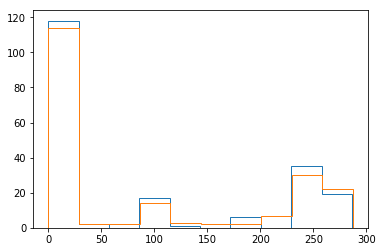

In [28]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

mean of the square root of the mean square of the differences

In [29]:
#RMSSD: mean of the square root of the mean square of the differences
# 1 split pval = .832
# 3 split pval = .765
# 6 split pval = nan?

signal = get_signal('IBI', 3, 12)
list = []
# Define analysis function

def MeanofStd_test(signal):
    #for splitno in range(n_splits):
    v = np.sqrt(np.mean(np.square(np.diff(signal))))
    return v

# Test function
MeanofStd_test(signal)




0.09745227012559321

In [30]:

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('IBI',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = MeanofStd_test(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 294.50it/s]


ANOVA P-value = 0.002


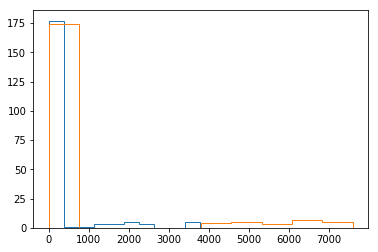

In [31]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

mean IBI

In [32]:
#test for mean IBI

# 1 split pval = .831
# 3 split pval = .765
# 6 split pval = .691

signal = get_signal('IBI', 3, 12)
list = []
# Define analysis function

def Mean(signal):
    for splitno in range(n_splits):
        list.append(st.mean(signal))
    return st.mean(list)

# Test function
Mean(signal)



0.803162

In [33]:

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('IBI',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = Mean(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 61.92it/s]


ANOVA P-value = 0.765


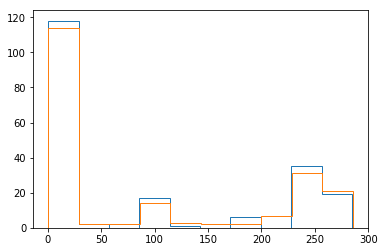

In [34]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

NNxx: sum absolute differences that are larger than 50ms

In [35]:
# NNxx: sum absolute differences that are larger than 50ms


# 1 split pval = .813
# 3 split pval = .680
# 6 split pval = .517

signal = get_signal('IBI', 3, 12)
list = [ 
NNxx(signal)


SyntaxError: unexpected EOF while parsing (<ipython-input-35-c07fb5ed4184>, line 10)

In [36]:
allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('IBI',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = NNxx(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

  0%|          | 0/33 [00:00<?, ?it/s]


NameError: name 'NNxx' is not defined

ANOVA P-value = nan


/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3219: RuntimeWarning: Mean of empty slice.
  offset = alldata.mean()
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3222: RuntimeWarning: invalid value encountered in double_scalars
  sstot = _sum_of_squares(alldata) - (_square_of_sums(alldata) / bign)
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3225: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / len(a)
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3229: RuntimeWarning: invalid value encountered in double_scalars
  ssbn -= _square_of_sums(alldata) / bign


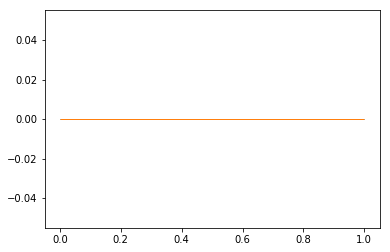

In [37]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

pNNx: fraction of nnxx of all rr-intervals

In [ ]:
# IGNORE THIS ONE IT DOESNT COMPILE(trying to fix)



# pNNx: fraction of nnxx of all rr-intervals
# 1 split pval = .813
# 3 split pval = .680
# 6 split pval = .517

signal = get_signal('IBI', 3, 12)
list = []
# Define analysis function

def pNNx(signal):
    for splitno in range(n_splits):
        list.append(100 * NNxx(signal) / len(signal))
    return scipy.mean(list)
# Test function
pNNx(signal)




In [ ]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

RR - intervals (differences between successive peaks)

In [ ]:
## IGNORE DOES NOT WORK 

from scipy.signal import find_peaks
signal = get_signal('IBI', 3, 12)
list = []

def peak(signal):
    for splitno in range(n_splits):
        peaks, similarity= find_peaks(signal)
       # rr = np.diff(peaks)
      #  list.append(rr)
    return st.mean(peaks)
# Test function
peak(signal)



In [ ]:
allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('IBI',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature = peak(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

In [ ]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

## Rebecca's Work Below This Line!

In [38]:
#just testing to see how things work

# STD with 1 split
signal = get_signal('IBI', 3, 12)

# Define analysis function

def IBI_test(signal):
    return scipy.mean(signal)

# Test function
IBI_test(signal)

0.803162

In [39]:
#attempting to find LF/HF ratio
#Get sample signal

signal = get_signal('IBI', 3, 12)

#Define analysis function
def ibi_passbands(signal):
    fs,pxx = sig.periodogram(signal, nfft = 1000, scaling = 'density', detrend = 'constant')

    vlfband = (fs > 0.0033)*(fs < 0.04)
    lfband = (fs > 0.04)*(fs < 0.15)
    hfband = (fs > 0.15) * (fs < 0.4)

    vlf_integral = np.trapz(pxx[vlfband],fs[vlfband]) #unsure what this does
    lf_integral = np.trapz(pxx[lfband],fs[lfband])
    hf_integral = np.trapz(pxx[hfband],fs[hfband])

    return [vlf_integral,lf_integral,hf_integral]

#test function

ibi_passbands(signal)

[0.00024016656560907706, 0.00173628307267934, 0.003353883387386369]

In [40]:
#sample lf/hf

signal = get_signal('IBI', 3, 12)

# Define analysis function

def IBI_lfhf(signal):
    return ibi_passbands(signal)[1]/ibi_passbands(signal)[2]

# Test function
IBI_lfhf(signal) 

0.5176933340047936

In [41]:
# Compute feature for entire dataset

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            hr_signal = get_split_signal('IBI',epoch,subjno,splitno) ## CHANGE THIS TO WHICHEVER SIGNAL YOU WANT
            

            allfeature =  IBI_lfhf(hr_signal) ## CHANGE THIS LINE HERE WITH YOUR OWN FUNCTION
            
            allfeatures.append(allfeature)
            targets.append(is_perturbed(epoch))

allfeature_names = ['my_feature'] ## You can leave this the way it is for simplicity. 
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:00<00:00, 112.55it/s]


ANOVA P-value = 0.027


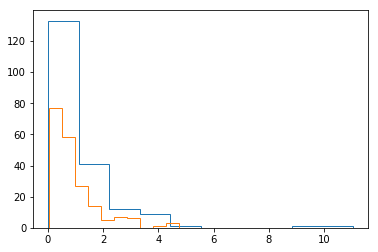

In [44]:
# Evaluate feature

targets = np.asarray(targets)
up = np.asarray(fdf['my_feature'][targets == 0])
p = np.asarray(fdf['my_feature'][targets == 1])

plt.hist(up,histtype = 'step')
plt.hist(p, histtype = 'step')

pval = stats.f_oneway(up,p)[1]
if pval < 0.1:
    print('\033[31m', 'ANOVA P-value = %.3f'%pval, '\033[0m', sep='') # Significant P-values will be colorful :)
else:
     print('ANOVA P-value = %.3f'%pval)

In [43]:
nonan = (~np.isnan(p)) * (~np.isnan(up)) #Not sure what this all means, will think about this more later

stats.f_oneway(up[nonan],p[nonan])

F_onewayResult(statistic=4.903983983123495, pvalue=0.02736646689451526)